Demonstrating Flaws in the Illusion of Thinking
===============================================

Abstract
--------

 * This notebook attempts to demonstrate a few problems with the methodology in the paper
   titled "[The Illusion of Thinking: Understanding the Strengths and Limitations of Reasoning Models via the Lens of Problem Complexity](https://machinelearning.apple.com/research/illusion-of-thinking)"
   (Shojaee et al. 2025).

 * The Tower of Hanoi experiment is replicated, and the observed collapse is reproduced
   with various models.

 * Variations of the experiment demonstrate that the complexity level where the collapse
   occurs is sensitive to the prompt instructions regarding the output and to the token
   utilization of the chosen output format.

 * It is also confirmed that at high complexity levels, the output quality starts to
   degrade early into the output, long before the token budget would be exhausted.

 * Revision (2025-06-18):

    * the collapse of the length of the thinking text also has to do with the token budget:
      the models realize that the output could get too long so they resort to alternative
      plans like using simpler, pattern based approaches or assuming user mistake and
      deciding to show only segments of the moves list.

    * Gemini 2.5 Pro Preview 06-05 thinking lengths seem to be constant across all
      complexity levels and experiment variants.

The raw model responses and the processed data are available on
[GitHub](https://github.com/attilammagyar/illusion-of-thinking-collapse)
for further investigation.

Note: [Others also have pointed out problems with the experiments](https://arxiv.org/abs/2506.09250v1).
I was unaware of this paper when I started working on this notebook. Revision (2025-06-19):
though this paper [was initially intended as a joke](https://lawsen.substack.com/p/when-your-joke-paper-goes-viral)
by naming Claude Opus as the main author, it actually does point out legitimate problems
with the original experiments.

Revision (2025-06-18)
---------------------

 * Ran the experiments for more complexity levels around the point where the apparent
   collapse occurs.

 * Plots now include the length of the thoughts of the reasoning models.

 * Reasoning tokens are now archived along with the failed answers in the [GitHub repository](https://github.com/attilammagyar/illusion-of-thinking-collapse/blob/gh-pages/data).

Introduction
------------

The Illusion of Thinking (Shojaee et al. 2025) paper claims that above a certain
problem complexity, Large Language Models (LLMs) and Large Reasoning Models (LRMs)
collapse and fail to produce accurate solutions. The observations are based on
experiments where the AI models are instructed to generate a solution to various
puzzle problems with different complexity levels (e.g. Tower of Hanoi with varying
number of disks, etc.). A solution is represented as a sequence of moves that
are to be performed in the game environment. The moves are specified in a format
similar to nested JSON lists.

I suspect there might be multiple problems with the presented method which may
contribute to the observed collapse, independently from the true capabilities
of the language models:

1. **Truncated responses**: preliminary investigation seems to indicate that
   despite the clear instructions in the system prompt, some models will often
   still truncate the list of moves at high complexity levels where the required
   number of moves exceeds certain limits. Sometimes they only provide the first
   and the last handful of moves, accompanied by a piece of Python or other
   program code to generate the rest, or by a confirmation message asking whether
   the user really wants to have the entire long list generated in a subsequent
   conversation message. An iterative, paginated or streamed approach could
   potentially overcome this issue, however, it could significantly increase the
   token costs, and it would also complicate the response processing framework.

2. **Token wasting**: moreover, partly due to the token-inefficient
   representation of the solution moves, some of the puzzles at high complexity
   levels require so many tokens (numbers, commas, spaces, brackets, etc.) that
   they are close to the maximum number of tokens allowed for some models and
   APIs, especially with the presence of chain-of-thought (CoT) reasoning
   tokens (thinking).

3. **Randomness**: the relatively high temperature setting ($T=1.0$), though
   required by some models (e.g. Anthropic Claude models), might increase the
   chances of the sampling process selecting a problematic token which then
   could have a cascading effect due to the autoregressive nature of the
   text generation algorithm.

Additionally, allowing models to utilize techniques that humans use when solving
similarly complex puzzles with pen and paper may improve the performance of the
models, while the lack of such techniques may contribute to the observed
collapse:

1. **Record keeping**: e.g. in the Tower of Hanoi experiment, the models are not
   instructed explicitly to keep track of the game state corresponding to their
   moves. Solving the proposed puzzles without maintaining a written record of
   the game state in each step could cause a similar collapse to occur even for
   humans, possibly at much lower complexity levels. However, this kind of record
   keeping would further increase the output token count, and possibly confuse
   some models. Also, it would further increase the willingness of the models
   to truncate the output.

2. **Mistake correction**: the models are not provided with any means to revise
   accidental problems should they arise by a potentially problematic token
   after it has been added to the output sequence. Especially for models where
   reasoning is not in use, being instructed to regularly review the emitted
   moves and append corrections if necessary may improve the accuracy.

I am going to investigate the Tower of Hanoi problem, and attempt to improve
the model performance past the reported collapsing complexity levels. However,
the token limits and the conditioning of the models in this regard still
significantly constrain the possibilities.

Models
------

 * `claude-3-7-sonnet-20250219` by [Anthropic](https://www.anthropic.com/) (with and without CoT),
 * `deepseek-chat` (DeepSeek V3 as of June 2025) by [DeepSeek](https://www.deepseek.com/en) (without CoT),
 * `gemini-2.5-pro-preview-06-05` by [Google](https://gemini.google.com/) (with CoT),
 * `gpt-4.1-2025-04-14` by [OpenAI](https://openai.com/) (without CoT),
 * `sonar-reasoning-pro` by [Perplexity AI](https://sonar.perplexity.ai/) (with CoT; powered by DeepSeek R1).


Tower of Hanoi Experiments
--------------------------

Each experiment will be repeated 10 times. (The original paper used 25 repeats.)

### Baseline

A reproduction of the original experiment with a lower temperature for reduced
randomness. Models and APIs will use a temperature of T=0.5 where possible.
(Anthropic Claude models require T=1.0 when thinking is used.)

### Adjusted Prompt

The output format remains the same as in the original experiment, but the
prompt will emphasize the requirement for the complete list of moves, as
well as encourage more economical output token usage (e.g. by omitting
indentation and spacing).

### CSV Moves

The moves must be specified as rows of comma-seaparated values (CSV), reducing
the output token usage by eliminating bracket characters and whitespace, while
maintaining automatic parsability.

### State Tracking, Mistake Correction

The moves will be specified as rows of comma-separated values (CSV), and instead of
specifying only the disk to be moved, the models will be instructed to maintain the
list of disks on all three pegs after each move. This information will not be
validated in its entirety, but it will be used for converting the moves into the
same format as the original so that the same validations can be performed.

The models will also be provided with an error correction mechanism by introducing
a sequential identifier for each move: if a CSV row is emitted with an already used
identifier, then this row will overwrite any previous ones with the same sequence
number, allowing the models to change their minds after emitting a wrong move.

### Results

 * The baseline experiment successfully reproduced the collapse reported in
   the paper.

 * The adjusted prompt reduced the average accuracy of Sonar Reasoning Pro and
   the non-thinking version of Claude Sonnet 3.7, but it deferred the first
   invalid move for most models at high complexity levels. It also caused a
   noticable improvement in the performance of the Gemini 2.5 Pro Preview
   and the DeepSeek V3 models.

 * Using the more token-efficient CSV format seems to further improve the
   performance of most models, both in terms of accuracy and the position
   of the first invalid move.

 * Game state tracking and its increased token usage had a negative effect on
   the performance of all models, while the provided self-correction mechanism
   remained under-utilized.

 * Manual inspection of some of the model responses which failed to produce a
   complete list of moves and to achieve the goal state indicate the occurrence
   of different problems:

    * Move lists often still get truncated at high complexity levels. The
      emphasis put on the requirement of the move list in its entirety in the
      prompt often fails to achieve its goal, but encourages the modesl to
      include lengthy apologies for truncating the output despite the
      instructions.

    * In multiple cases, the models emit invalid moves early in their final
      answers at high complexity levels, long before the length of the output
      sequence would approach the allowed token budget. This is observed both
      in the presence and absence of CoT tokens.

    * Revision (2025-06-18): the collapse of the length of the thinking text
      also has to do with the token budget: the models realize that the output
      could get too long if they try to manually trace the algorithm (especially
      when they chose to take somewhat lengthy notes along each step) so they
      abandon that plan and resort to alternative approaches, like using simpler,
      pattern based approaches or assuming user mistake and deciding to show only
      segments of the moves list.

      Gemini 2.5 Pro Preview 06-05 however seems to use a constant thinking
      length across all complexity levels and experiment variants.

    * Revision (2025-06-19): once the answer length pushes models to cut corners
      and use a pattern-based approach rather than risking token budge exhaustion
      via tracing the correct algorithm, the parity of the number of disks starts
      to affect the results.

Formal testing of the statistical significance of the observed performance
differences, maybe on a larger sample size, is left for the reader.

The raw model responses and the processed data are available in the
[GitHub repository](https://github.com/attilammagyar/illusion-of-thinking-collapse),
in the `cache` and the `data` folders respectively.

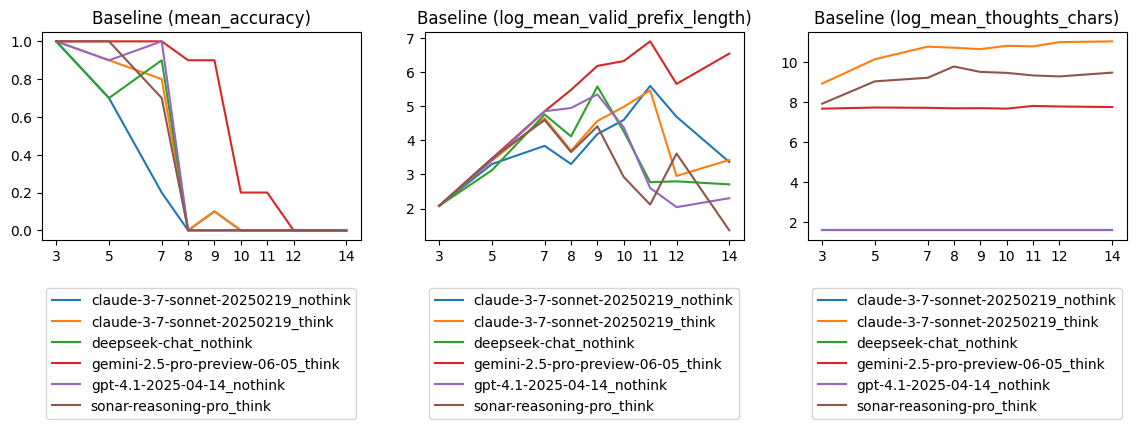

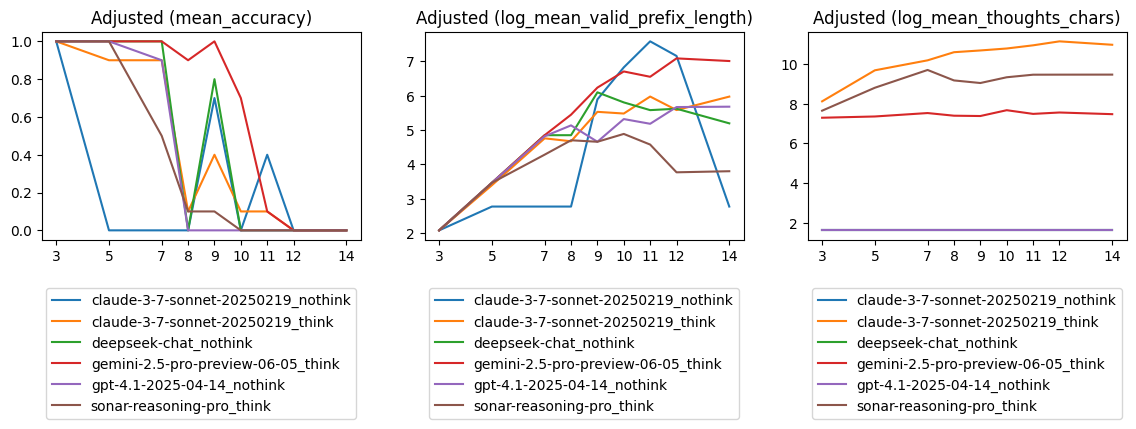

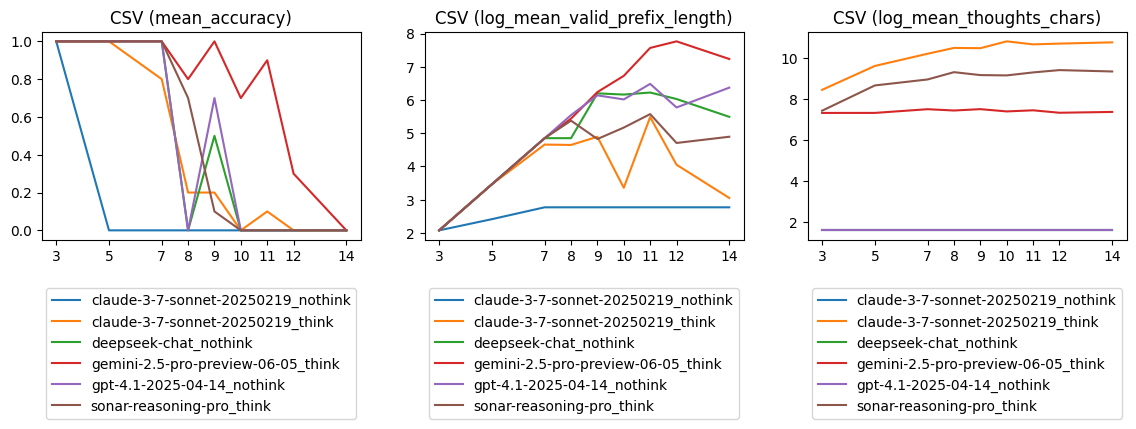

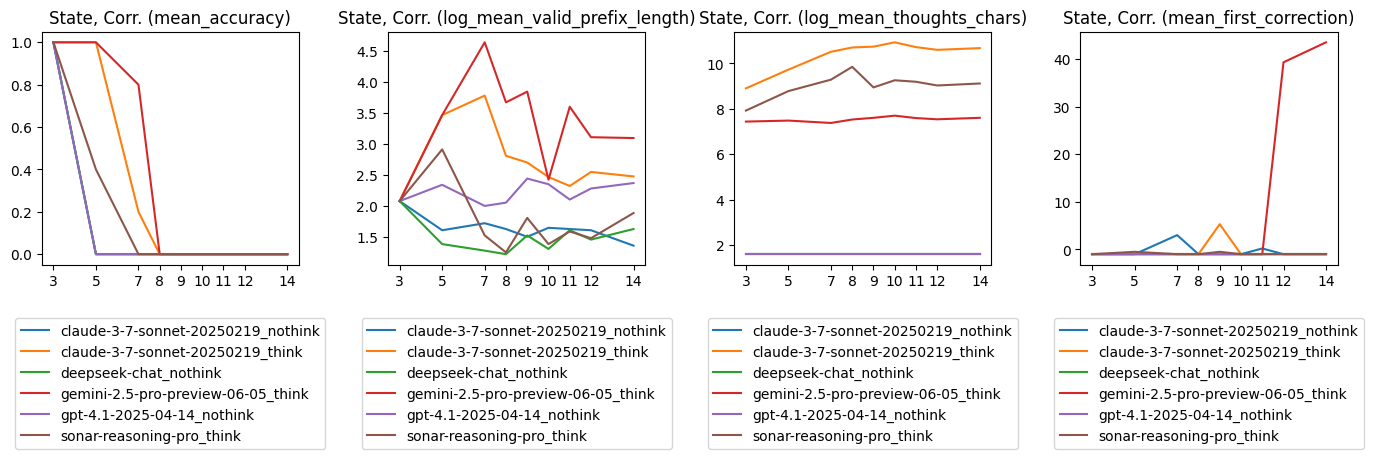

In [17]:
try:
    plot_hanoi_results(
        hanoi_base_results,
        hanoi_adj_results,
        hanoi_csv_results,
        hanoi_trck_results
    )
except:
    print("Run all the blocks in the Appendix: Code section first.")

## Conclusion

It has been demonstrated that the problem complexity level where the performance
collapse occurs is sensitive to the format specification of the output, and can
be improved by using a more token-efficient output format. Therefore, it is not likely
to be the limit of the capacity of the models, instead, the limit of model output
length conditioning and token budget.

Appendix: Code
--------------

### Dependencies

In [1]:
# !pip install matplotlib==3.10.0
# !pip install numpy==2.2.3
# !pip install pandas==2.2.3
# !pip install requests==2.32.3

In [2]:
import collections as coll
import collections.abc as collabc
import functools
import gzip
import hashlib
import html.parser
import json
import os
import os.path
import random
import re
import sys
import time
import typing
import urllib.parse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

### API keys

My personal API keys are not included in the public repository, so generating new
model responses will require setting these up. See the api-keys.json.example file
for the details. Note however that the notebook can be run without any API keys if the
`cache` directory from the GitHub repository is available.

In [3]:
api_keys_filename = "api-keys.json"

if not os.path.isfile(api_keys_filename):
    raise RuntimeError(f"API keys file not found: {api_keys_filename!r}")

with open(api_keys_filename, "r") as f:
    api_keys = json.load(f)


print("API keys: " + ", ".join(sorted(api_keys.keys())))

API keys: anthropic, deepseek, google, openai, perplexity


### Common Utilities

This block contains a convenience function for sending the same system and user
prompts to all the models, as well as various cached HTTP request related utilities.

Caching all the requests and responses makes debugging and re-running the notebook
easier and quicker, but sensitive and potentially sensitive data like API keys and
various identifiers need to be removed from the cached data so that they are safe
to be published on GitHub.

In [4]:
MAX_OUT_TOKENS = 64000
MAX_REASONING_TOKENS = 32000
TEMPERATURE = 0.5

MODELS = {
    "sonnet": "claude-3-7-sonnet-20250219",
    "deepseek": "deepseek-chat",  # DeepSeek-V3 as of Jun 2025
    "gemini": "gemini-2.5-pro-preview-06-05",
    "gpt4": "gpt-4.1-2025-04-14",
    "perplexity": "sonar-reasoning-pro",
}

MODEL_FN = {}

MODEL_R = {
    "sonnet": [0, MAX_REASONING_TOKENS],
    "deepseek": [0],
    "gemini": [MAX_REASONING_TOKENS],
    "gpt4": [0],
    "perplexity": [MAX_REASONING_TOKENS],
}


def query_all(
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
):
    for model_name, query_fn in MODEL_FN.items():
        for reasoning_budget in MODEL_R[model_name]:
            response, thoughts = query_fn(
                experiment_name,
                system_prompt,
                user_prompt,
                temperature,
                max_out_tokens,
                reasoning_budget,
            )

            yield MODELS[model_name], reasoning_budget, response, thoughts


def send_cached_post_request(
        cache_filename: str,
        url: str,
        request_headers: collabc.Mapping,
        request_body: collabc.Mapping,
        sensitive_headers: collabc.Container=(),
        sensitive_body_fields: collabc.Container=(),
):
    sensitive_headers = {h.lower() for h in sensitive_headers}
    sensitive_body_fields = {f.lower() for f in sensitive_body_fields}

    cache_dir = os.path.dirname(cache_filename)

    os.makedirs(cache_dir, exist_ok=True)
    
    if os.path.isfile(cache_filename):
        with gzip.open(cache_filename, "rt") as f:
            return json.load(f)
    
    try:
        response = requests.post(url, headers=request_headers, json=request_body)
        response.raise_for_status()

        result = {
            "request": {
                "headers": del_items(request_headers, sensitive_headers),
                "body": del_items(request_body, sensitive_body_fields),
            },
            "response": {
                "headers": del_items(response.headers, sensitive_headers),
                "body": del_items(response.json(), sensitive_body_fields),
            }
        }

        with gzip.open(cache_filename, "wt", compresslevel=9) as f:
            json.dump(result, f, indent=2)

        return result

    except Exception as exc:
        print(f"Exception: ({type(exc)}) {exc}")

        if hasattr(exc, "response") and exc.response is not None:
            print(f"Response status code: {exc.response.status_code}")
            print(f"Response body: {exc.response.text}")

        raise


def build_cache_filename(experiment_name: str, model_name: str, temperature: float):
    experiment_name = experiment_name.strip()
    experiment_dir = os.path.dirname(experiment_name)
    experiment_file = os.path.basename(experiment_name)

    if experiment_dir == "":
        experiment_dir = experiment_file

    return os.path.join(
        "cache",
        experiment_dir,
        (f"{experiment_file}-{model_name}-t{temperature:.3f}".replace(".", "_")) + ".json.gz",
    )


def get_item(container, path: str, default=None):
    """
    Extract data from nested dicts and lists based on a dot-separated
    path string. See test_get_item() for examples.
    """

    if path == "." or path == "":
        return container

    path = path.split(".")

    for key in path:
        if isinstance(container, collabc.Mapping):
            if key in container:
                container = container[key]
            else:
                return default
        elif isinstance(container, collabc.Sequence):
            if int(key) < len(container):
                container = container[int(key)]
            else:
                return default
        else:
            return default

    return container


def del_items(container, patterns: typing.List[str]):
    """
    Return a copy of a nested dicts and lists object with the
    values matching the given set of dot-separated paths removed.
    The "*" character acts as a wildcard. See test_del_items()
    for examples.
    """

    def should_include(path: list, exclude_patterns: typing.List[tuple]) -> bool:
        return not any(path_matches_pattern(path, ptrn) for ptrn in exclude_patterns)

    def copy_recursive(obj, path: list, exclude_patterns: typing.List[tuple]):
        if isinstance(obj, str):
            return obj

        if isinstance(obj, collabc.Mapping):
            copy = {}

            for k, v in obj.items():
                path_ext = path + [k]

                if should_include(path_ext, exclude_patterns):
                    copy[k] = copy_recursive(v, path_ext, exclude_patterns)

            return copy

        if isinstance(obj, collabc.Sequence):
            copy = []

            for k, v in enumerate(obj):
                path_ext = path + [str(k)]

                if should_include(path_ext, exclude_patterns):
                    copy.append(copy_recursive(v, path_ext, exclude_patterns))

            return copy

        return obj

    for pattern in patterns:
        if pattern == "." or pattern == "":
            return ValueError(f"Invalid pattern; {pattern=!r}")

    patterns = [tuple(pattern.lower().split(".")) for pattern in patterns]
    
    return copy_recursive(container, [], patterns)


def path_matches_pattern(path: collabc.Sequence, pattern: collabc.Sequence) -> bool:
    if len(path) != len(pattern):
        return False

    for path_component, pattern_component in zip(path, pattern):
        matches = (
            pattern_component == "*"
            or pattern_component == path_component.lower()
        )

        if not matches:
            return False

    return True


def split_lines(text: str) -> list:
    """
    Normalize line-breaks (Windows, Linux, Mac, etc.) then split
    the given text into separate lines.
    """

    return (
        text.replace("\r\n", "\n")
            .replace("\r", "\n")
            .strip()
            .split("\n")
    )


def test_get_item():
    container = {"aaa": [{"bbb": "42", "ccc": "123"}]}

    assert_eq("42", get_item(container, "aaa.0.bbb"))
    assert_eq(None, get_item(container, "aaa.2.zzz"))


def test_del_items():
    container = {"aaa": [{"bbb": "42", "ccc": "123", "ddd": "hello"}]}

    assert_eq({"aaa": [{"ddd": "hello"}]}, del_items(container, ["aaa.*.ccc", "*.*.bbb", "zzz"]))


def assert_eq(a, b):
    assert a == b, f"Failed to assert that a = b; {a=!r}, {b=!r}"


test_get_item()
test_del_items()

### API Clients

#### Anthropic Claude Client

In [5]:
def query_claude_sonnet(
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_budget: int=MAX_REASONING_TOKENS,
):
    # https://docs.anthropic.com/en/api/messages

    model_name = MODELS["sonnet"]
    suffix = "-nothink"
    thinking = {"type": "disabled"}

    # https://console.anthropic.com/settings/limits
    max_out_tokens = min(64000, max_out_tokens)

    if reasoning_budget > 0:
        # Thinking requires temperature to be exactly 1.
        temperature = 1
        reasoning_budget = min(int(max_out_tokens * 0.7) + 1, reasoning_budget)
        suffix = "-think"
        thinking = {
            "type": "enabled",
            "budget_tokens": reasoning_budget,
        }

    cache_filename = build_cache_filename(experiment_name, model_name + suffix, temperature)
    request_headers = {
        "x-api-key": api_keys["anthropic"],
        "anthropic-version": "2023-06-01",
        "content-type": "application/json"
    }
    request_body = {
        "model": model_name,
        "max_tokens": max_out_tokens,
        "temperature": temperature,
        "stream": False,
        "system": system_prompt,
        "thinking": thinking,
        "messages": [
            {"role": "user", "content": user_prompt}
        ]
    }
    result = send_cached_post_request(
        cache_filename,
        "https://api.anthropic.com/v1/messages",
        request_headers,
        request_body,
        sensitive_headers=["x-api-key", "anthropic-organization-id", "request-id", "CF-RAY"],
        sensitive_body_fields=["id"],
    )

    text = None
    thoughts = None
    
    for content in get_item(result, "response.body.content"):
        content_type = get_item(content, "type")

        if content_type == "text":
            text = content["text"]
        elif content_type == "thinking":
            thoughts = content["thinking"]

    return text, thoughts


MODEL_FN["sonnet"] = query_claude_sonnet

#### DeepSeek Client

In [6]:
def query_deepseek(
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_budget: int=MAX_REASONING_TOKENS,
):
    # https://api-docs.deepseek.com/api/create-chat-completion

    if reasoning_budget > 0:
        raise NotImplementedError()
    
    max_out_tokens = min(8192, max_out_tokens)
    model_name = MODELS["deepseek"]
    cache_filename = build_cache_filename(experiment_name, model_name + "-nothink", temperature)
    request_headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + api_keys["deepseek"],
    }
    request_body = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        "max_tokens": max_out_tokens,
        "response_format": {"type": "text"},
        "stream": False,
        "temperature": temperature,
    }
    result = send_cached_post_request(
        cache_filename,
        "https://api.deepseek.com/chat/completions",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "Set-Cookie", "x-ds-trace-id", "CF-RAY"],
        sensitive_body_fields=["id"],
    )

    text = None
    thoughts = None
    
    for choice in get_item(result, "response.body.choices"):
        if get_item(choice, "message.role") == "assistant":
            text = get_item(choice, "message.content")

    return text, thoughts


MODEL_FN["deepseek"] = query_deepseek

#### Google Gemini Client

In [7]:
def query_gemini(
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_budget: int=MAX_REASONING_TOKENS,
        system_prompt_key: str="systemInstruction",
):
    # https://ai.google.dev/gemini-api/docs/text-generation
    # https://ai.google.dev/api/generate-content#method:-models.generatecontent

    reasoning_budget = min(32768, reasoning_budget)
    max_out_tokens = max(reasoning_budget + 128, max_out_tokens)
    
    model_name = MODELS["gemini"]
    suffix = "-nothink"
    thinking = {
        "includeThoughts": False,
        "thinkingBudget": 0,
    }

    if reasoning_budget > 0:
        suffix = "-think"
        thinking = {
            "includeThoughts": True,
            "thinkingBudget": reasoning_budget,
        }

    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "Content-Type": "application/json",
    }
    request_body = {
        system_prompt_key: {
            "parts": [{"text": system_prompt}],
        },
        "contents": [
            {"parts": [{"text": user_prompt}]},
        ],
        "generationConfig": {
            "temperature": temperature,
            "maxOutputTokens": max_out_tokens,
            "responseModalities": ["text"],
            "thinkingConfig": thinking,
        },
    }
    url = "".join(
        (
            "https://generativelanguage.googleapis.com/v1beta/models/",
            urllib.parse.quote_plus(model_name),
            ":generateContent?key=",
            urllib.parse.quote_plus(api_keys["google"]),
        )
    )
    result = send_cached_post_request(
        cache_filename,
        url,
        request_headers,
        request_body,
        sensitive_headers=[],
        sensitive_body_fields=[],
    )

    text = None
    thoughts = None
    
    for candidate in get_item(result, "response.body.candidates"):
        if get_item(candidate["content"], "role") == "model":
            for part in get_item(candidate, "content.parts"):
                part_text = get_item(part, "text")

                if part_text is not None:
                    if get_item(part, "thought"):
                        thoughts = part_text
                    else:
                        text = part_text

    return text, thoughts


MODEL_FN["gemini"] = query_gemini

As of June, 2025, some of the API documentation of Gemini uses
[snake_case](https://ai.google.dev/gemini-api/docs/text-generation#system-instructions)
for the system prompt field, other parts of the documentation use
[camelCase](https://ai.google.dev/api/generate-content#method:-models.generatecontent).
The code below attempts to use both in order to see if any or both
are actually accepted by the API.

In [8]:
print("# system_instruction:")
print(
    query_gemini(
        'pirate-snake_case',
        "Talk like a pirate.",
        "Explain in one brief sentence why the sky is blue.",
        system_prompt_key="system_instruction",
    )[0]
)
print("")
print("# systemInstruction:")
print(
    query_gemini(
        'pirate-camelCase',
        "Talk like a pirate.",
        "Explain in one brief sentence why the sky is blue.",
        system_prompt_key="systemInstruction",
    )[0]
)

# system_instruction:
Arrr, the air o' this world scatters the sun's golden light and sends the blue bits a-flyin' all across the sky

# systemInstruction:
Arrr, the air above scatters the sun's blue light 'round the heavens more than the other colors, and that be what yer eyes catch, matey


#### OpenAI Client

In [9]:
def query_openai(
        model_name: str,
        accepts_temperature: bool,
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_budget: int=MAX_REASONING_TOKENS,
):
    # https://platform.openai.com/docs/guides/text?api-mode=responses
    # https://platform.openai.com/docs/api-reference/responses/create

    if reasoning_budget > 0:
        raise NotImplementedError()

    cache_filename = build_cache_filename(experiment_name, model_name + "-nothink", temperature)
    request_headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + api_keys["openai"],
    }
    request_body = {
        "model": model_name,
        "max_output_tokens": max_out_tokens,
        "input": [
            {"role": "developer", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        "stream": False,
    }

    if accepts_temperature:
        request_body["temperature"] = temperature
    
    result = send_cached_post_request(
        cache_filename,
        "https://api.openai.com/v1/responses",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "openai-organization", "openai-project", "x-request-id", "Set-Cookie", "CF-RAY"],
        sensitive_body_fields=["id", "output.*.id"],
    )

    text = None
    thoughts = None
    
    for output in get_item(result, "response.body.output"):
        if get_item(output, "type") == "message" and get_item(output, "role") == "assistant":
            for content in get_item(output, "content", []):
                if get_item(content, "type") == "output_text":
                    text = get_item(content, "text")

    return text, thoughts


query_gpt4 = functools.partial(query_openai, MODELS["gpt4"], True)

MODEL_FN["gpt4"] = query_gpt4

#### Perplexity AI Client

In [10]:
def query_perplexity(
        experiment_name: str,
        system_prompt: str,
        user_prompt: str,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_budget: int=MAX_REASONING_TOKENS,
):
    # https://docs.perplexity.ai/guides/getting-started
    # https://docs.perplexity.ai/api-reference/chat-completions

    model_name = MODELS["perplexity"]

    cache_filename = build_cache_filename(experiment_name, model_name + "-think", temperature)
    request_headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "Authorization": "Bearer " + api_keys["perplexity"],
    }
    request_body = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        "max_tokens": max_out_tokens,
        "temperature": temperature,
        "return_related_questions": False,
        "stream": False,
        "web_search_options": {
            "search_context_size": "low",
        },
    }
    result = send_cached_post_request(
        cache_filename,
        "https://api.perplexity.ai/chat/completions",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "Set-Cookie", "CF-RAY", ],
        sensitive_body_fields=["id"],
    )

    text = None
    thoughts = None
    
    for choice in get_item(result, "response.body.choices"):
        if get_item(choice, "message.role") == "assistant":
            response = get_item(choice, "message.content").split("</think>", 1)

    if len(response) == 1:
        text = response[0]
    elif len(response) == 2:
        thoughts = response[0]

        if thoughts.startswith("<think>"):
            thoughts = thoughts[7:]

        text = response[1]

    return text, thoughts


MODEL_FN["perplexity"] = query_perplexity

### Tower of Hanoi

In [11]:
def solve_tower_of_hanoi(experiment_name_tpl, system_prompt, user_prompt_tpl, temperature, repeats, parser_fn):
    backlog = []
    results = {
        "experiment": [],
        "n": [],
        "i": [],
        "model": [],
        "reasoning_budget": [],
        "temperature": [],
        "response_chars": [],
        "thoughts_chars": [],
        "first_correction": [],
        "valid_prefix_length": [],
        "is_valid_solution": [],
    }

    for n in [14, 12, 11, 10, 9, 8, 7, 5, 3]:
        for i in range(repeats):
            experiment_name = os.path.join(experiment_name_tpl, f"{experiment_name_tpl}-{n}-{i}")
            backlog.append((experiment_name, 0, n, i))

    while len(backlog) > 0:
        experiment_name, tries, n, i = backlog.pop(0)

        try:
            user_prompt = user_prompt_tpl.replace("$N$", str(n))
            responses = query_all(experiment_name, system_prompt, user_prompt, temperature=temperature)

            for model_name, reasoning_budget, response, thoughts in responses:
                response = str(response)
                thoughts = str(thoughts)

                log_1 = f"# {model_name=!r}, {reasoning_budget=}, {tries=}, {n=}, {i=}"

                print(f"# {len(backlog)=}")
                print(log_1)

                response_chars = len(response)
                thoughts_chars = len(thoughts)
                moves, first_correction = parser_fn(response)
                valid_prefix_length, is_valid_solution = evaluate_moves(n, moves)

                log_2 = f"# {valid_prefix_length=}, {is_valid_solution=}, {first_correction=}"

                print(log_2)
                print("")

                if not is_valid_solution:
                    think = "think" if reasoning_budget > 0 else "nothink"
                    filename_base = f"invalid_answer-{experiment_name_tpl}-{model_name}-{think}-n{n}-i{i}-t{temperature:.1f}"
                    filename_base = filename_base.replace(".", "_") + ".txt"
                    invalid_answer_filename = os.path.join(
                        "data",
                        f"hanoi-invalid-answers-{experiment_name_tpl}",
                        filename_base,
                    )
                    os.makedirs(os.path.dirname(invalid_answer_filename), exist_ok=True)

                    with open(invalid_answer_filename, "w") as f:
                        print(log_1, file=f)
                        print(log_2, file=f)
                        print("", file=f)
                        print("<think>", file=f)
                        print(thoughts, file=f)
                        print("</think>", file=f)
                        print("", file=f)
                        print(response, file=f)
                        print("", file=f)

                results["experiment"].append(experiment_name_tpl)
                results["n"].append(n)
                results["i"].append(i)
                results["model"].append(model_name)
                results["reasoning_budget"].append(reasoning_budget)
                results["temperature"].append(temperature)
                results["response_chars"].append(response_chars)
                results["thoughts_chars"].append(thoughts_chars)
                results["first_correction"].append(first_correction)
                results["valid_prefix_length"].append(valid_prefix_length)
                results["is_valid_solution"].append(is_valid_solution)

        except AssertionError:
            raise
            
        except Exception as exc:
            print(f"  Exception ({tries=}): ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((experiment_name, tries + 1, n, i))
            time.sleep(max(3, min(5, tries)))

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", f"{experiment_name_tpl}.csv"), index=False)

    return results_df


def parse_tower_of_hanoi_moves_orig(response):
    moves = []
    parts = re.split(
        r" *moves *= *\[ *",
        response
            .replace("\t", " ")
            .replace("\r", "\n")
    )

    for part in parts[1:]:
        moves = []
        stack = [moves]
        num = ""

        for line in part.split("\n"):
            line = line.split("#", 1)[0]

            for char in line:
                if len(stack) < 1:
                    break
                    
                stack_top = stack[-1]

                if char == "[":
                    new_list = []
                    stack_top.append(new_list),
                    stack.append(new_list)
                    num = ""

                elif char == "]":
                    if num != "":
                        stack_top.append(int(num))
                        num = ""

                    stack.pop()

                elif char.isnumeric():
                    num += char

                else:
                    if num != "":
                        stack_top.append(int(num))
                        num = ""

            if len(stack) < 1:
                break

        if len(stack) > 0 and num != "":
            stack_top = stack[-1]
            stack_top.append(int(num))
            num = ""

    return moves, -1


def parse_tower_of_hanoi_moves_csv(response):
    parts = response.lower().replace("\r", "\n").split("```")

    moves = []
    is_code_block = len(parts) != 1

    for part in parts:
        is_code_block = not is_code_block

        if not is_code_block:
            continue

        moves_in_part = []
        
        for line in part.split("\n"):
            cols = [c.strip() for c in line.strip().split(",")]

            if len(cols) != 3 or not all(c.strip().isnumeric() for c in cols):
                continue

            moves_in_part.append([int(c.strip()) for c in cols])

        if len(moves_in_part) > 0:
            moves = moves_in_part

    return moves, -1


def parse_tower_of_hanoi_moves_csv_state(response):
    parts = response.lower().replace("\r", "\n").split("```")

    moves = []
    first_correction = -1
    is_code_block = len(parts) != 1

    for part in parts:
        is_code_block = not is_code_block

        if not is_code_block:
            continue

        moves_in_part = []
        
        for line in part.split("\n"):
            cols = [c.strip() for c in line.strip().split(",")]

            if len(cols) != 6 or not all(c.strip().isnumeric() for c in cols[0:3]):
                continue

            move_id = int(cols[0].strip()) - 1
            from_peg = int(cols[1].strip())
            to_peg = int(cols[2].strip())
            pegs = [
                [int(d.strip()) for d in c.split(" ") if d.strip().isnumeric()]
                for c in cols[3:]
            ]

            # Only using from the puzzle state what's necessary - it is meant
            # mostly to help the model. However, invalid state tracking will
            # produce invalid moves anyways.
            disk_id = (
                pegs[to_peg][-1]
                if to_peg >= 0 and to_peg <= 2 and len(pegs[to_peg]) > 0
                else 0
            )

            if move_id < len(moves_in_part):
                moves_in_part[move_id] = [disk_id, from_peg, to_peg]

                if first_correction == -1:
                    first_correction = move_id
            else:
                moves_in_part.append([disk_id, from_peg, to_peg])

        if len(moves_in_part) > 0:
            moves = moves_in_part

    return moves, first_correction


def evaluate_moves(n, moves):
    pegs = [
        list(range(n, 0, -1)),
        [],
        [],
    ]

    valid_prefix_length = 0

    for move in moves:
        if not isinstance(move, list):
            continue
            
        if not (isinstance(move, list) and len(move) == 3):
            break

        disk_id, from_peg, to_peg = move

        if from_peg < 0 or from_peg > 2:
            break

        if to_peg < 0 or to_peg > 2:
            break
        
        if len(pegs[from_peg]) < 1:
            break

        if pegs[from_peg][-1] != disk_id:
            break

        if from_peg == to_peg:
            # Nobody said explicitly to use the minimal number of moves.
            continue
        
        if len(pegs[to_peg]) > 0 and pegs[to_peg][-1] < disk_id:
            break

        pegs[from_peg].pop()
        pegs[to_peg].append(disk_id)
        valid_prefix_length += 1

    is_valid_solution = (
        len(pegs[0]) == 0
        and len(pegs[1]) == 0
        and pegs[2] == list(range(n, 0, -1))
    )

    return valid_prefix_length, 1 if is_valid_solution else 0
    

def test_parse_tower_of_hanoi_moves():
    response_0 = "nope"
    moves_0 = []
    first_correction_0 = -1

    response_1 = """\
Here's a list of moves:

```
moves = [[1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
         [1, 1, 0], [2, 1, 2], [1, 0, 99]]
```

No, wait, I made a mistake, here's a better one:

```
moves = [[1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
         [1, 1, 0], [2, 1, 2], [1, 0, 2]]
```
"""
    moves_1 = [
        [1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
        [1, 1, 0], [2, 1, 2], [1, 0, 2],
    ]
    first_correction_1 = -1

    response_2 = """\
```csv
move_id,from_peg,to_peg,peg0,peg1,peg2
1,0,2,3 2,,1
2,0,1,3,2,1
3,2,1,3,2 1,
4,0,2,,2 1,3
5,2,0,1,2,3
6,1,0,1,,3 2
5,1,0,1,2,3
6,1,2,1,,3 2
7,0,2,,,3 2 1
```
"""
    moves_2 = [
        [1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
        [1, 1, 0], [2, 1, 2], [1, 0, 2],
    ]
    first_correction_2 = 4

    response_3 = """\
```
disk_id,from_peg,to_peg
1,0,2
2,0,1
1,2,1
3,0,2
1,1,0
2,1,2
1,0,2
```
"""
    moves_3 = [
        [1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
        [1, 1, 0], [2, 1, 2], [1, 0, 2],
    ]
    first_correction_3 = -1

    response_4 = """\
```
move_id,from_peg,to_peg,peg0,peg1,peg2
1,0,2,14 13 12 11 10 9 8 7 6 5 4 3 2,,1
2,0,1,14 13 12 11 10 9 8 7 6 5 4 3,2,1
3,2,1,14 13 12 11 10 9 8 7 6 5 4 3,2 1,
```
"""
    moves_4 = [
        [1, 0, 2],
        [2, 0, 1],
        [1, 2, 1],        
    ]
    first_correction_4 = -1
    
    assert_eq((moves_0, first_correction_0), parse_tower_of_hanoi_moves_orig(response_0))
    assert_eq((moves_1, first_correction_1), parse_tower_of_hanoi_moves_orig(response_1))
    assert_eq((moves_2, first_correction_2), parse_tower_of_hanoi_moves_csv_state(response_2))
    assert_eq((moves_3, first_correction_3), parse_tower_of_hanoi_moves_csv(response_3))
    assert_eq((moves_4, first_correction_4), parse_tower_of_hanoi_moves_csv_state(response_4))


def test_evaluate_moves():
    moves_0 = []
    moves_1 = [
        [1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
        [1, 1, 0], [2, 1, 2], [1, 0, 2],
    ]
    moves_2 = [
        [1, 0, 2],
        [2, 0, 1],
        123, # ignored
        [1, 2, 1],
        [3, 0, 2],
        [1, 1, 0],
        [2, 1, 0],
    ]
    moves_4 = [
        [1, 0, 2],
        [2, 0, 1],
        [1, 2, 1],        
    ]

    assert_eq((0, False), evaluate_moves(3, moves_0))
    assert_eq((7, True), evaluate_moves(3, moves_1))
    assert_eq((5, False), evaluate_moves(3, moves_2))
    assert_eq((3, False), evaluate_moves(14, moves_4))


test_parse_tower_of_hanoi_moves()
test_evaluate_moves()

#### Baseline

In [12]:
hanoi_base_sys = """\
You are a helpful assistant. Solve this puzzle for me.

There are three pegs and $n$ disks of different sizes stacked on the first peg. \
The disks are numbered from 1 (smallest) to $n$ (largest). Disk moves in this \
puzzle should follow:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one stack and placing it on \
top of another stack.
3. A larger disk may not be placed on top of a smaller disk.

The goal is to move the entire stack to the third peg.

**Example**: With 3 disks numbered 1 (smallest), 2, and 3 (largest), the initial \
state is `[[3, 2, 1], [], []]`, and a solution might be:

```
moves = [[1, 0, 2], [2, 0, 1], [1, 2, 1], [3, 0, 2],
         [1, 1, 0], [2, 1, 2], [1, 0, 2]]
```

This means: Move disk 1 from peg 0 to peg 2, then move disk 2 from peg 0 to peg 1, \
and so on.

**Requirements**:
- When exploring potential solutions in your thinking process, always include the \
corresponding complete list of moves.
- The positions are 0-indexed (the leftmost peg is 0).
- Ensure your final answer includes the complete list of moves in the format:

```
moves = [[disk id, from peg, to peg], ...]
```
"""

hanoi_base_usr_tpl = """\
I have a puzzle with $N$ disks of different sizes with

**Initial configuration**:
- Peg 0: $N$ (bottom), ... 2, 1 (top)
- Peg 1: (empty)
- Peg 2: (empty)

**Goal configuration**:
- Peg 0: (empty)
- Peg 1: (empty)
- Peg 2: $N$ (bottom), ... 2, 1 (top)

**Rules**:
- Only one disk can be moved at a time.
- Only the top disk from any stack can be moved.
- A larger disk may not be placed on top of a smaller disk.

Find the sequence of moves to transform the initial configuration into the \
goal configuration.
"""


hanoi_base_results = solve_tower_of_hanoi(
    "hanoi-base",
    hanoi_base_sys,
    hanoi_base_usr_tpl,
    temperature=0.5,
    repeats=10,
    parser_fn=parse_tower_of_hanoi_moves_orig,
)

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=159, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=0, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='deepseek-chat', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=16, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gemini-2.5-pro-preview-06-05', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=767, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gpt-4.1-2025-04-14', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=0, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='sonar-reasoning-pro', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=0, is_valid_solution=0, first_correction=-1

# len(b

#### Adjusted Prompt

In [13]:
hanoi_adj_sys = """\
You are a deterministic and highly obedient assistant which outputs complete, \
untruncated solutions, regardless of length. Please solve this puzzle for me.

There are three pegs and $n$ disks of different sizes stacked on the first peg. \
The disks are numbered from 1 (smallest) to $n$ (largest). Disk moves in this \
puzzle should follow:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one stack and placing it on \
top of another stack.
3. A larger disk may not be placed on top of a smaller disk.

The goal is to move the entire stack to the third peg.

**Example**: With 3 disks numbered 1 (smallest), 2, and 3 (largest), the initial \
state is `[[3,2,1],[],[]]`, and a solution might be:

```
moves=[[1,0,2],[2,0,1],[1,2,1],[3,0,2],[1,1,0],[2,1,2],[1,0,2]]
```

This means: Move disk 1 from peg 0 to peg 2, then move disk 2 from peg 0 to peg 1, \
and so on.

**Requirements**:
- When exploring potential solutions in your thinking process, always include the \
corresponding complete list of moves.
- The positions are 0-indexed (the leftmost peg is 0).
- Ensure your final answer includes the complete list of moves in the format:

```
moves=[[disk_id,from_peg,to_peg],...]
```

Your output will be parsed automatically, so nice identation, whitespace, and \
human readability of the list don't matter. Do not truncate or summarize the output. \
Output the entire move list in full, even if it is long. This is required for task \
success.
"""

hanoi_adj_usr_tpl = """\
I have a puzzle with $N$ disks of different sizes with

**Initial configuration**:
- Peg 0: $N$ (bottom), ... 2, 1 (top)
- Peg 1: (empty)
- Peg 2: (empty)

**Goal configuration**:
- Peg 0: (empty)
- Peg 1: (empty)
- Peg 2: $N$ (bottom), ... 2, 1 (top)

**Rules**:
- Only one disk can be moved at a time.
- Only the top disk from any stack can be moved.
- A larger disk may not be placed on top of a smaller disk.

Find the sequence of moves to transform the initial configuration into the \
goal configuration.

**Note**:
- I really do want you to enumerate all the moves. Please do not truncate the list, \
however long it may be. I do insist. Do not ask for confirmation, just output the \
complete list of moves please.
- You don't have to format and indent the list nicely for readability, because \
it will be parsed automatically. Feel free to omit any whitespace from the list.
- I don't need any explanation, just the raw and complete list of moves in the \
specified format.
- This is a benchmark test where the first invalid or incomplete move you generate \
matters. The more valid and parsable moves you generate from the optimal solution, \
the better your score will be. Truncating the list in any way risks a very low \
score. Therefore your best strategy is to attempt to output the complete list, \
even if you risk running out of output tokens.
"""


hanoi_adj_results = solve_tower_of_hanoi(
    "hanoi-adj",
    hanoi_adj_sys,
    hanoi_adj_usr_tpl,
    temperature=0.1,
    repeats=10,
    parser_fn=parse_tower_of_hanoi_moves_orig,
)

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=15, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=1279, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='deepseek-chat', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=79, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gemini-2.5-pro-preview-06-05', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=1535, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gpt-4.1-2025-04-14', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=87, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='sonar-reasoning-pro', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=39, is_valid_solution=0, first_correction=-1

# 

#### CSV Moves

In [14]:
hanoi_csv_sys = """\
You are a deterministic and highly obedient assistant which outputs complete, \
untruncated solutions, regardless of length. Please solve this puzzle for me.

There are three pegs and $n$ disks of different sizes stacked on the first peg. \
The disks are numbered from 1 (smallest) to $n$ (largest). Disk moves in this \
puzzle should follow:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one stack and placing it on \
top of another stack.
3. A larger disk may not be placed on top of a smaller disk.

The goal is to move the entire stack to the third peg.

**Example**: With 3 disks numbered 1 (smallest), 2, and 3 (largest), the initial \
state is `[3,2,1],[],[]`, and a solution might be:

```
disk_id,from_peg,to_peg
1,0,2
2,0,1
1,2,1
3,0,2
1,1,0
2,1,2
1,0,2
```

This means: Move disk 1 from peg 0 to peg 2, then move disk 2 from peg 0 to peg 1, \
and so on.

**Requirements**:
- When exploring potential solutions in your thinking process, always include the \
corresponding complete list of moves.
- The positions are 0-indexed (the leftmost peg is 0).
- Ensure your final answer includes the complete CSV list of moves with the \
following columns:

```
disk_id,from_peg,to_peg
```

The meaning of the columns:
- **disk_id**: the number of the disk that is being moved. (Goes from 1 to $n$.)
- **from_peg**: from which peg the disk is being removed. (0, 1, or 2.)
- **to_peg**: to which peg the disk is being placed. (0, 1, or 2.)

Your output will be parsed automatically. Do not truncate or summarize the moves. \
Output the entire move list in full, even if it is long. This is required for task \
success.
"""

hanoi_csv_usr_tpl = """\
I have a puzzle with $N$ disks of different sizes with

**Initial configuration**:
- Peg 0: $N$ (bottom), ... 2, 1 (top)
- Peg 1: (empty)
- Peg 2: (empty)

**Goal configuration**:
- Peg 0: (empty)
- Peg 1: (empty)
- Peg 2: $N$ (bottom), ... 2, 1 (top)

**Rules**:
- Only one disk can be moved at a time.
- Only the top disk from any stack can be moved.
- A larger disk may not be placed on top of a smaller disk.

Find the sequence of moves to transform the initial configuration into the \
goal configuration.

**Note**:
- I really do want you to enumerate all the moves. Please do not truncate the list, \
however long it may be. I do insist. Do not ask for confirmation, just output the \
complete list of moves please.
- I don't need any explanation, just the raw and complete list of moves in the \
specified format.
- This is a benchmark test where the first invalid move you generate matters. \
The more valid and parsable moves you generate from the optimal solution, the \
better your score will be. Truncating the list in any way risks a low score. \
Therefore your best strategy is to attempt to output the complete list, even \
if you risk running out of output tokens.
"""


hanoi_csv_results = solve_tower_of_hanoi(
    "hanoi-csv",
    hanoi_csv_sys,
    hanoi_csv_usr_tpl,
    temperature=0.1,
    repeats=10,
    parser_fn=parse_tower_of_hanoi_moves_csv,
)

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=15, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=15, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='deepseek-chat', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=79, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gemini-2.5-pro-preview-06-05', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=1535, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gpt-4.1-2025-04-14', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=703, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='sonar-reasoning-pro', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=127, is_valid_solution=0, first_correction=-1

# 

#### State Tracking, Mistake Correction

In [15]:
hanoi_trck_sys = """\
You are a deterministic and highly obedient assistant which outputs complete, \
untruncated solutions, regardless of length. Please solve this puzzle for me.

There are three pegs and $n$ disks of different sizes stacked on the first peg. \
The disks are numbered from 1 (smallest) to $n$ (largest). Disk moves in this \
puzzle should follow:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one stack and placing it on \
top of another stack.
3. A larger disk may not be placed on top of a smaller disk.

The goal is to move the entire stack to the third peg.

**Example**: With 3 disks numbered 1 (smallest), 2, and 3 (largest), the initial \
state is `[3, 2, 1], [], []`, and a solution might be:

```
move_id,from_peg,to_peg,peg0,peg1,peg2
1,0,2,3 2,,1
2,0,1,3,2,1
3,2,1,3,2 1,
4,0,2,,2 1,3
5,1,0,1,2,3
6,1,2,1,,3 2
7,0,2,,,3 2 1
```

This means: Move disk 1 from peg 0 to peg 2, then move disk 2 from peg 0 to peg 1, \
and so on. The peg0, peg1, and peg2 columns represent the state of each peg after \
the move.

**Requirements**:
- When exploring potential solutions in your thinking process, always include the \
corresponding complete list of moves.
- The positions are 0-indexed (the leftmost peg is 0).
- Ensure your final answer includes the complete list of moves and the resulting \
peg states in the format:

```
move_id,from_peg,to_peg,peg0,peg1,peg2
```

The meaning of the columns:
- **move_id**: the ordinal number of the move starting from 1. For each move id, only \
its last instance is considered, so if you notice any previous mistakes while generating \
the list, you can fix the incorrect rows anytime by outputting the same move ids again \
with the corrected values.
- **from_peg**: from which peg the disk is being removed. (0, 1, or 2.)
- **to_peg**: to which peg the disk is being placed. (0, 1, or 2.)
- **peg0**: the state of the first peg after the move, represented as a space separated \
list of disk numbers going from the bottom to the top.
- **peg1**: the state of the second peg after the move, with the same format as above.
- **peg2**: the state of the third peg after the move, with the same format as above.

**Example with error correction**:

```
move_id,from_peg,to_peg,peg0,peg1,peg2
1,0,2,3 2,,1
2,0,1,3,2,1
3,2,1,3,2 1,
4,0,2,,2 1,3
5,2,0,1,2,3
6,1,0,1,,3 2
5,1,0,1,2,3
6,1,2,1,,3 2
7,0,2,,,3 2 1
```

Your output will be parsed automatically. Make sure that you strictly stick to the \
specified format. Regularly check if a correction is necessary, and if so, output the \
appropriate correction rows. Do not truncate or summarize the output. Output the \
entire move and state list in full, even if it is long. This is required for task \
success.
"""

hanoi_trck_usr_tpl = """\
I have a puzzle with $N$ disks of different sizes with

**Initial configuration**:
- Peg 0: $N$ (bottom), ... 2, 1 (top)
- Peg 1: (empty)
- Peg 2: (empty)

**Goal configuration**:
- Peg 0: (empty)
- Peg 1: (empty)
- Peg 2: $N$ (bottom), ... 2, 1 (top)

**Rules**:
- Only one disk can be moved at a time.
- Only the top disk from any stack can be moved.
- A larger disk may not be placed on top of a smaller disk.

Find the sequence of moves to transform the initial configuration into the \
goal configuration.

**Note**:
- I really do want you to enumerate all the moves. Please do not truncate the list, \
however long it may be. I do insist. Do not ask for confirmation, just output the \
complete list of moves please.
- I don't need any explanation, just the raw and complete list of moves in the \
specified format.
- This is a benchmark test where the first invalid move you generate matters (not \
counting those that you fix subsequently). The more valid and parsable moves you generate \
from the optimal solution, the better your score will be. Truncating the list in any \
way risks a low score. Therefore your best strategy is to attempt to output the \
complete list, even if you risk running out of output tokens.
"""


hanoi_trck_results = solve_tower_of_hanoi(
    "hanoi-trck",
    hanoi_trck_sys,
    hanoi_trck_usr_tpl,
    temperature=0.1,
    repeats=10,
    parser_fn=parse_tower_of_hanoi_moves_csv_state,
)

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=5, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='claude-3-7-sonnet-20250219', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=6, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='deepseek-chat', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=4, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gemini-2.5-pro-preview-06-05', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=14, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='gpt-4.1-2025-04-14', reasoning_budget=0, tries=0, n=14, i=0
# valid_prefix_length=4, is_valid_solution=0, first_correction=-1

# len(backlog)=89
# model_name='sonar-reasoning-pro', reasoning_budget=32000, tries=0, n=14, i=0
# valid_prefix_length=0, is_valid_solution=0, first_correction=-1

# len(backl

#### Plotting

In [16]:
def plot_hanoi_results(base_results_df, adj_results_df, csv_results_df, trck_results_df):
    for i, (title, results_df) in enumerate(
            (
                ("Baseline", base_results_df),
                ("Adjusted", adj_results_df),
                ("CSV", csv_results_df),
                ("State, Corr.", trck_results_df),
            )
    ):
        plot_cols = ["mean_accuracy", "log_mean_valid_prefix_length", "log_mean_thoughts_chars"]
        plot_height = 2.7

        if results_df["first_correction"].max() > -1.0:
            plot_cols.append("mean_first_correction")
            plot_height = 5
        
        axs = plt.subplots(1, len(plot_cols), figsize=(14, plot_height))[1]
        scores = (
            results_df
                .groupby(["experiment", "n", "model", "reasoning_budget", "temperature"])
                .mean()
                .reset_index()
                .rename(
                    columns={
                        "is_valid_solution": "mean_accuracy",
                        "valid_prefix_length": "mean_valid_prefix_length",
                        "first_correction": "mean_first_correction",
                        "thoughts_chars": "mean_thoughts_chars",
                    },
                )
        )
        scores["log_mean_valid_prefix_length"] = np.log1p(scores["mean_valid_prefix_length"])
        scores["log_mean_thoughts_chars"] = np.log1p(scores["mean_thoughts_chars"])

        for j, col in enumerate(plot_cols):
            ax = axs[j]

            for model in sorted(scores["model"].unique()):
                model_scores = scores[scores["model"] == model]
        
                for reasoning_budget in sorted(model_scores["reasoning_budget"].unique()):
                    model_variant_scores = model_scores[model_scores["reasoning_budget"] == reasoning_budget]
                    suffix = "_think" if reasoning_budget > 0 else "_nothink"
                    x = []
                    y = []
        
                    for n in sorted(model_variant_scores["n"].unique()):
                        x.append(n)
                        y.append(model_variant_scores[model_variant_scores["n"] == n][col].mean())
    
                    ax.plot(x, y, label=f"{model}{suffix}")
                    ax.set_xticks(x)
        
            ax.set_title(f"{title} ({col})")
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

    plt.tight_layout()
    plt.show()